- ALL MOVIES mental v. random to address reviewer concerns

created July 5, 2022

In [1]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'

In [3]:
#suff= ''
suff = '_corrected'

In [4]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
# even if using the Mental/Random labels, need this to sub-select subs who have responded on all trials
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape # subs *movies

(1049, 10)

In [5]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vidnames

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [6]:
print([len(np.where(~np.isnan(responses[s,:]))[0]) for s in range(20)])

[8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10]


In [7]:
# load reg coeffts 
coef_slope_all  = np.load(os.path.join(data_file_loc,f'coef_slopereg_all{suff}_MentalRandom.npy')) # YET TO BE CHANGED!!
coef_slope_all.shape

(1049, 268, 2)

# Statistics

In [8]:
from multipy.fdr import lsu

In [9]:
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

## All movies

In [10]:
# to get an estimate for how many subjects gave all 10 responses. In the data, subjects with <10 responaes have already been assigned an NaN value (so no need to select only good subjects again.)
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
len(np.where(count_resp == 10)[0])

814

In [11]:
pval_slope_all_unc = np.empty((268,))
meanDiff_sl_all =  np.empty_like(pval_slope_all_unc)
pval_slope_all_unc[:] = np.nan
meanDiff_sl_all[:] = np.nan

for n in range(268):
    dat = np.mean(coef_slope_all[:,n,:],axis=1)
    dat = dat[~np.isnan(dat)] # nan values are usually incomplete subjects (it's set that way in 2A_1_A_..allmovies.ipynb)
    _,pval_slope_all_unc[n] = stats.ttest_1samp(dat,0,nan_policy='omit')
    meanDiff_sl_all[n] = np.nanmean(dat)
pval_slope_all_corr = lsu(pval_slope_all_unc,q=.05)
pval_slope_all_unc = pval_slope_all_unc < .05

# Plot figs

In [13]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig3_glm_soc_vs_nonsoc/')

In [14]:
print('all arrays dividided by their std:')
print(f'ALL MOVIES:, min {min(meanDiff_sl_all/np.std(meanDiff_sl_all))}, max {max(meanDiff_sl_all/np.std(meanDiff_sl_all)):.2f}')

all arrays dividided by their std:
ALL MOVIES:, min -1.4653263668304441, max 3.48


- hence for scatterplots, min = -2, max = 4.5 in the function below.
- for the brain maps of rand and fish, we need actual un-normalized values: -.22,.55


In [15]:
def plot_fig(X,Y,xlabel,ylabel):
    #X = stats.zscore(X)
    X = X/np.nanstd(X)
    #Y = stats.zscore(Y)
    Y = Y/np.nanstd(Y)
    plt.plot(X,Y,ls='None',marker='.',alpha = .5,color='grey',label = 'mean "social"-"nonsocial"\nper node',markersize=8)
    r,p = stats.pearsonr(X,Y)
    
    plt.xlabel(xlabel+'/std')
    plt.ylabel(ylabel+'/std')
    xymin,xymax =  -2.5,4.5
    
    # best_fit_line(X,Y):
    m, b = np.polyfit(X,Y, 1)
    print(np.poly1d([m,b]))
    xplot = np.linspace(xymin,xymax,10)
    plt.plot(xplot, m*xplot + b,ls='dashed',color = 'k',label = 'line of \nbest fit\n(all nodes)') #plt.title(np.poly1d([m,b]))

    plt.xlim(xymin,xymax)
    plt.ylim(xymin,xymax)
    xpos = xymin#+ .01*(xmax-xmin)
    ypos = xymin+ .8*(xymax-xymin)
    #plt.text(xpos,ypos,f'r={r:.2f},\np={p:.1e}',fontsize=20)
    plt.annotate(f'r={r:.2f},\np={p:.1e}', xy=(.05, 0.85), xycoords='axes fraction')
    plt.xticks([-2,0,2,4])
    plt.yticks([-2,0,2,4])
    #plt.text(xymin,.7*xymax,f'sl.={m:.2f},\nint.={b:.2f}')
    plt.vlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
    plt.hlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
   

def plot_sig_nodes(X,Y,inds):
    #X = stats.zscore(X)
    X = X/np.nanstd(X)
    #Y = stats.zscore(Y)
    Y = Y/np.nanstd(Y)
    plt.plot(X[inds],Y[inds],ls='None',marker='o',mfc='w', mec='k',label = 'pair-wise sig.',ms=8)
    plt.plot(X[nodes_coaxbill_rand_all],Y[nodes_coaxbill_rand_all],ls='None',marker='o',
    mfc='k', mec='k',mew = 3, linewidth = 5,label = 'sig. across all\ncomparisons\nexcept FISH',ms=4)
    #plt.plot(X[nodes_coaxbill_rand_all_fish],Y[nodes_coaxbill_rand_all_fish],ls='None',marker='D',
    #mfc='g', mec='g',label = 'sig. across all\ncomparisons',ms=10)
    

In [16]:
fig_save_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig3_glm_soc_vs_nonsoc/'

## Plot brainmaps

In [17]:
#import plotting functions

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import plot_glass_brain
import nibabel as nib
from nilearn.plotting import plot_stat_map

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


lbl = [str.upper(x[0:4]) for x in vidnames]
#lbl

In [18]:
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.6...","{'coords': [9.599999999999994, 17.618823529411...","{'coords': [5.270633397312864, 35.032629558541...","{'coords': [15.647840531561457, 34.18604651162...","{'coords': [8.283887468030684, 46.058823529411...","{'coords': [14.581460674157299, 64.75280898876...","{'coords': [30.41914191419142, 54.795379537953...","{'coords': [44.469325153374236, 46.09509202453...","{'coords': [28.814814814814817, 51.16316316316...","{'coords': [8.521081081081078, 53.28, 23.88540...",...,"{'coords': [-10.399527186761233, 10.8770685579...","{'coords': [-14.491582491582491, -3.5488215488...","{'coords': [-24.77079107505071, 5.537525354969...","{'coords': [-9.427230046948353, -25.5399061032...","{'coords': [-4.68474576271187, -10.24067796610...","{'coords': [-11.407792207792212, -25.563636363...","{'coords': [-4.821052631578951, -21.5115789473...","{'coords': [-4.227272727272734, -37.8977272727...","{'coords': [-6.9375, -33.13068181818181, -39.3...","{'coords': [-5.697885196374628, -18.9667673716..."


In [19]:
def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [20]:
cols = ['k','grey','g']
lw = [3,2,1]

In [22]:
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_glass_brain, plot_surf_roi,plot_stat_map,plot_img,plot_surf_contours
from nilearn import datasets
bg_img = datasets.load_mni152_template()
from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()
#coords = [10*int(i) for i in np.linspace(-4,

destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
parcellation = destrieux_atlas['map_right']
np.unique(parcellation).shape

(75,)

In [23]:
# these are the regions we want to outline
regions_dict = {b'G_postcentral': 'Postcentral gyrus',
                b'G_precentral': 'Precentral gyrus'}

# get indices in atlas for these labels
regions_indices = [np.where(np.array(destrieux_atlas['labels']) == region)[0][0]
                   for region in regions_dict]
regions_indices

[28, 29]

In [24]:
def surf_plot(fig,ax,nodes,params):
    title_txt = params['title']
    txt  = params['txt']
    vmin = params['vmin']
    vmax = params['vmax']

    #LH
    ax_surf = ax[0,0]
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot1.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot1.axes[0].set_title(title_txt,fontsize=20,color='k',ha='left')
    texture_contour = vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot1, legend=True,levels = [1], colors=['k'])
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/surf_left_lat.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

    ax_surf = ax[1,0]
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot2.axes[1].text(4,.8*vmax,s= txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot2.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot2, legend=True,levels = [1], colors=['k'])
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/surf_left_med.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

    #RH
    ax_surf = ax[0,1]
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot3.axes[1].text(4,.8*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot3.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    texture_contour = vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot3, legend=True,levels = [1], colors=['k'])
    surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    #surf_plot3.axes[4].colorbar
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/surf_right_lat.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    box = surf_plot3.axes[4].get_position()
    surf_plot3.axes[4].set_position([box.x0*.93, box.y0-.3, box.width, box.height*2])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    

    ax_surf = ax[1,1]
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    #surf_plot4.axes[0].set_title(title_txt,fontsize=24,color='k',fontweight='bold')
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    #plt.savefig(os.path.join(fig_save_loc,f'RAND/surf_right_med.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

    
    ax[0,0].dist = 7 # change viewing distance to "zoom in" to surface plots
    ax[0,1].dist = 7
    ax[1,0].dist = 7
    ax[1,1].dist = 7

    #fig.colorbar(surf_plot3.axes[2])
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.0, 
                        hspace=-.1)
    #fig.colorbar(surf_plot2, shrink=2, aspect=10)
#box = surf_plot3.axes[4].get_position()
#surf_plot3.axes[4].set_position([box.x0, box.y0, box.width, box.height])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    

In [25]:
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy'))

In [26]:
coords = [-44,-34,-24] # initial exploration

In [27]:
 -max(meanDiff_sl_all),max(meanDiff_sl_all)

(-0.3963453970428949, 0.3963453970428949)

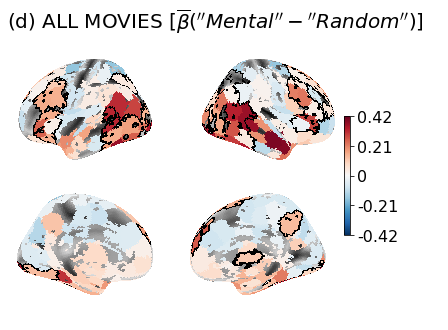

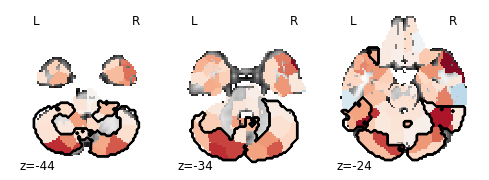

In [29]:
#vmin,vmax = -max(meanDiff_sl_all),max(meanDiff_sl_all)
vmin,vmax = -.42,.42 # to make it comparable to the response-based all movies analysis
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'

title_txt = '(d) ALL MOVIES ['r"$\overline{\beta}(''Mental''-''Random'')$"']'
txt = '      '
#txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)

nodes = np.zeros((268,))
nodes[pval_slope_all_unc] = meanDiff_sl_all[pval_slope_all_unc]

fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
ax[0,0].set_title(title_txt,loc='left',fontsize=20)
fig.set_tight_layout(False)
params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
surf_plot(fig,ax,nodes,params)
plt.savefig(os.path.join(fig_save_loc,f'ALL_MentalRandom/surf_all4.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

img = roi_to_brain(pd.Series(nodes), mask_x)
#coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
#ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
ax_plot.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=1, colors=['k'],linestyles ='-',filled=False)
plt.savefig(os.path.join(fig_save_loc,f'ALL_MentalRandom/axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


# Plot timecourses

In [652]:
tcs_run_z.shape

(1048, 268, 31, 10)

In [654]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
print(vid_start_rel_tr)
l_task = 28

def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):

    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan

    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1
    

#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\nrun-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy') # load fmri data
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_run_z.shape)
tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind)
print('after:',tcs_run_z.shape)

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm{suff}.npy') # load fmri data
tcs_trial_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_z.shape)
tcs_trial_z = remove_pretrial_TRs(tcs_trial_z,vid_start_rel_tr,tr0_ind)
print('after:',tcs_trial_z.shape)


# collapse across movies and runs (for timecourse plots)

tcs_run_resh_yes = []
tcs_run_resh_no = []
tcs_run_resh_unsure = []
subs_resh_yes = []
subs_resh_no = []
subs_resh_unsure = []
for m in range(0,10):
    tcs_run_resh_yes.append(tcs_run_z[responses[:,m]==1,:,:,m])# subsm * 268 * 31
    tcs_run_resh_no.append(tcs_run_z[responses[:,m]==0,:,:,m])# subsm * 268 * 31
    tcs_run_resh_unsure.append(tcs_run_z[responses[:,m]==9,:,:,m])# subsm * 268 * 31
    subs_resh_yes += list(np.where(responses[:,m]==1)[0])# subsm * 268 * 31, keep track of subject seq
    subs_resh_no  += list(np.where(responses[:,m]==0)[0])# subsm * 268 * 31
    subs_resh_unsure  += list(np.where(responses[:,m]==9)[0])# subsm * 268 * 31
tcs_run_resh_yes = np.concatenate(tcs_run_resh_yes,axis=0)
tcs_run_resh_no  = np.concatenate(tcs_run_resh_no,axis=0)
tcs_run_resh_unsure  = np.concatenate(tcs_run_resh_unsure,axis=0)
print('Across all movies: \nyes:'+ str(tcs_run_resh_yes.shape) + ',\nno:' + str(tcs_run_resh_no.shape) + ',\nunsure:' + str(tcs_run_resh_unsure.shape))

#np.concatenate((movieTC_yes,movieTC_no),axis=0).shape

[6 13 13 13 13 6 13 13 13 13]

run-wise norm data.
before: (1049, 268, 56, 10)
after: (1049, 268, 31, 10)

trial-wise norm data.
before: (1049, 268, 56, 10)
after: (1049, 268, 31, 10)
Across all movies: 
yes:(4956, 268, 31),
no:(4411, 268, 31),
unsure:(671, 268, 31)


In [655]:
TR = .72

# get the right red/blue shades
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255

alpha = .2 # transparency inside boxplots, for datapts etc.

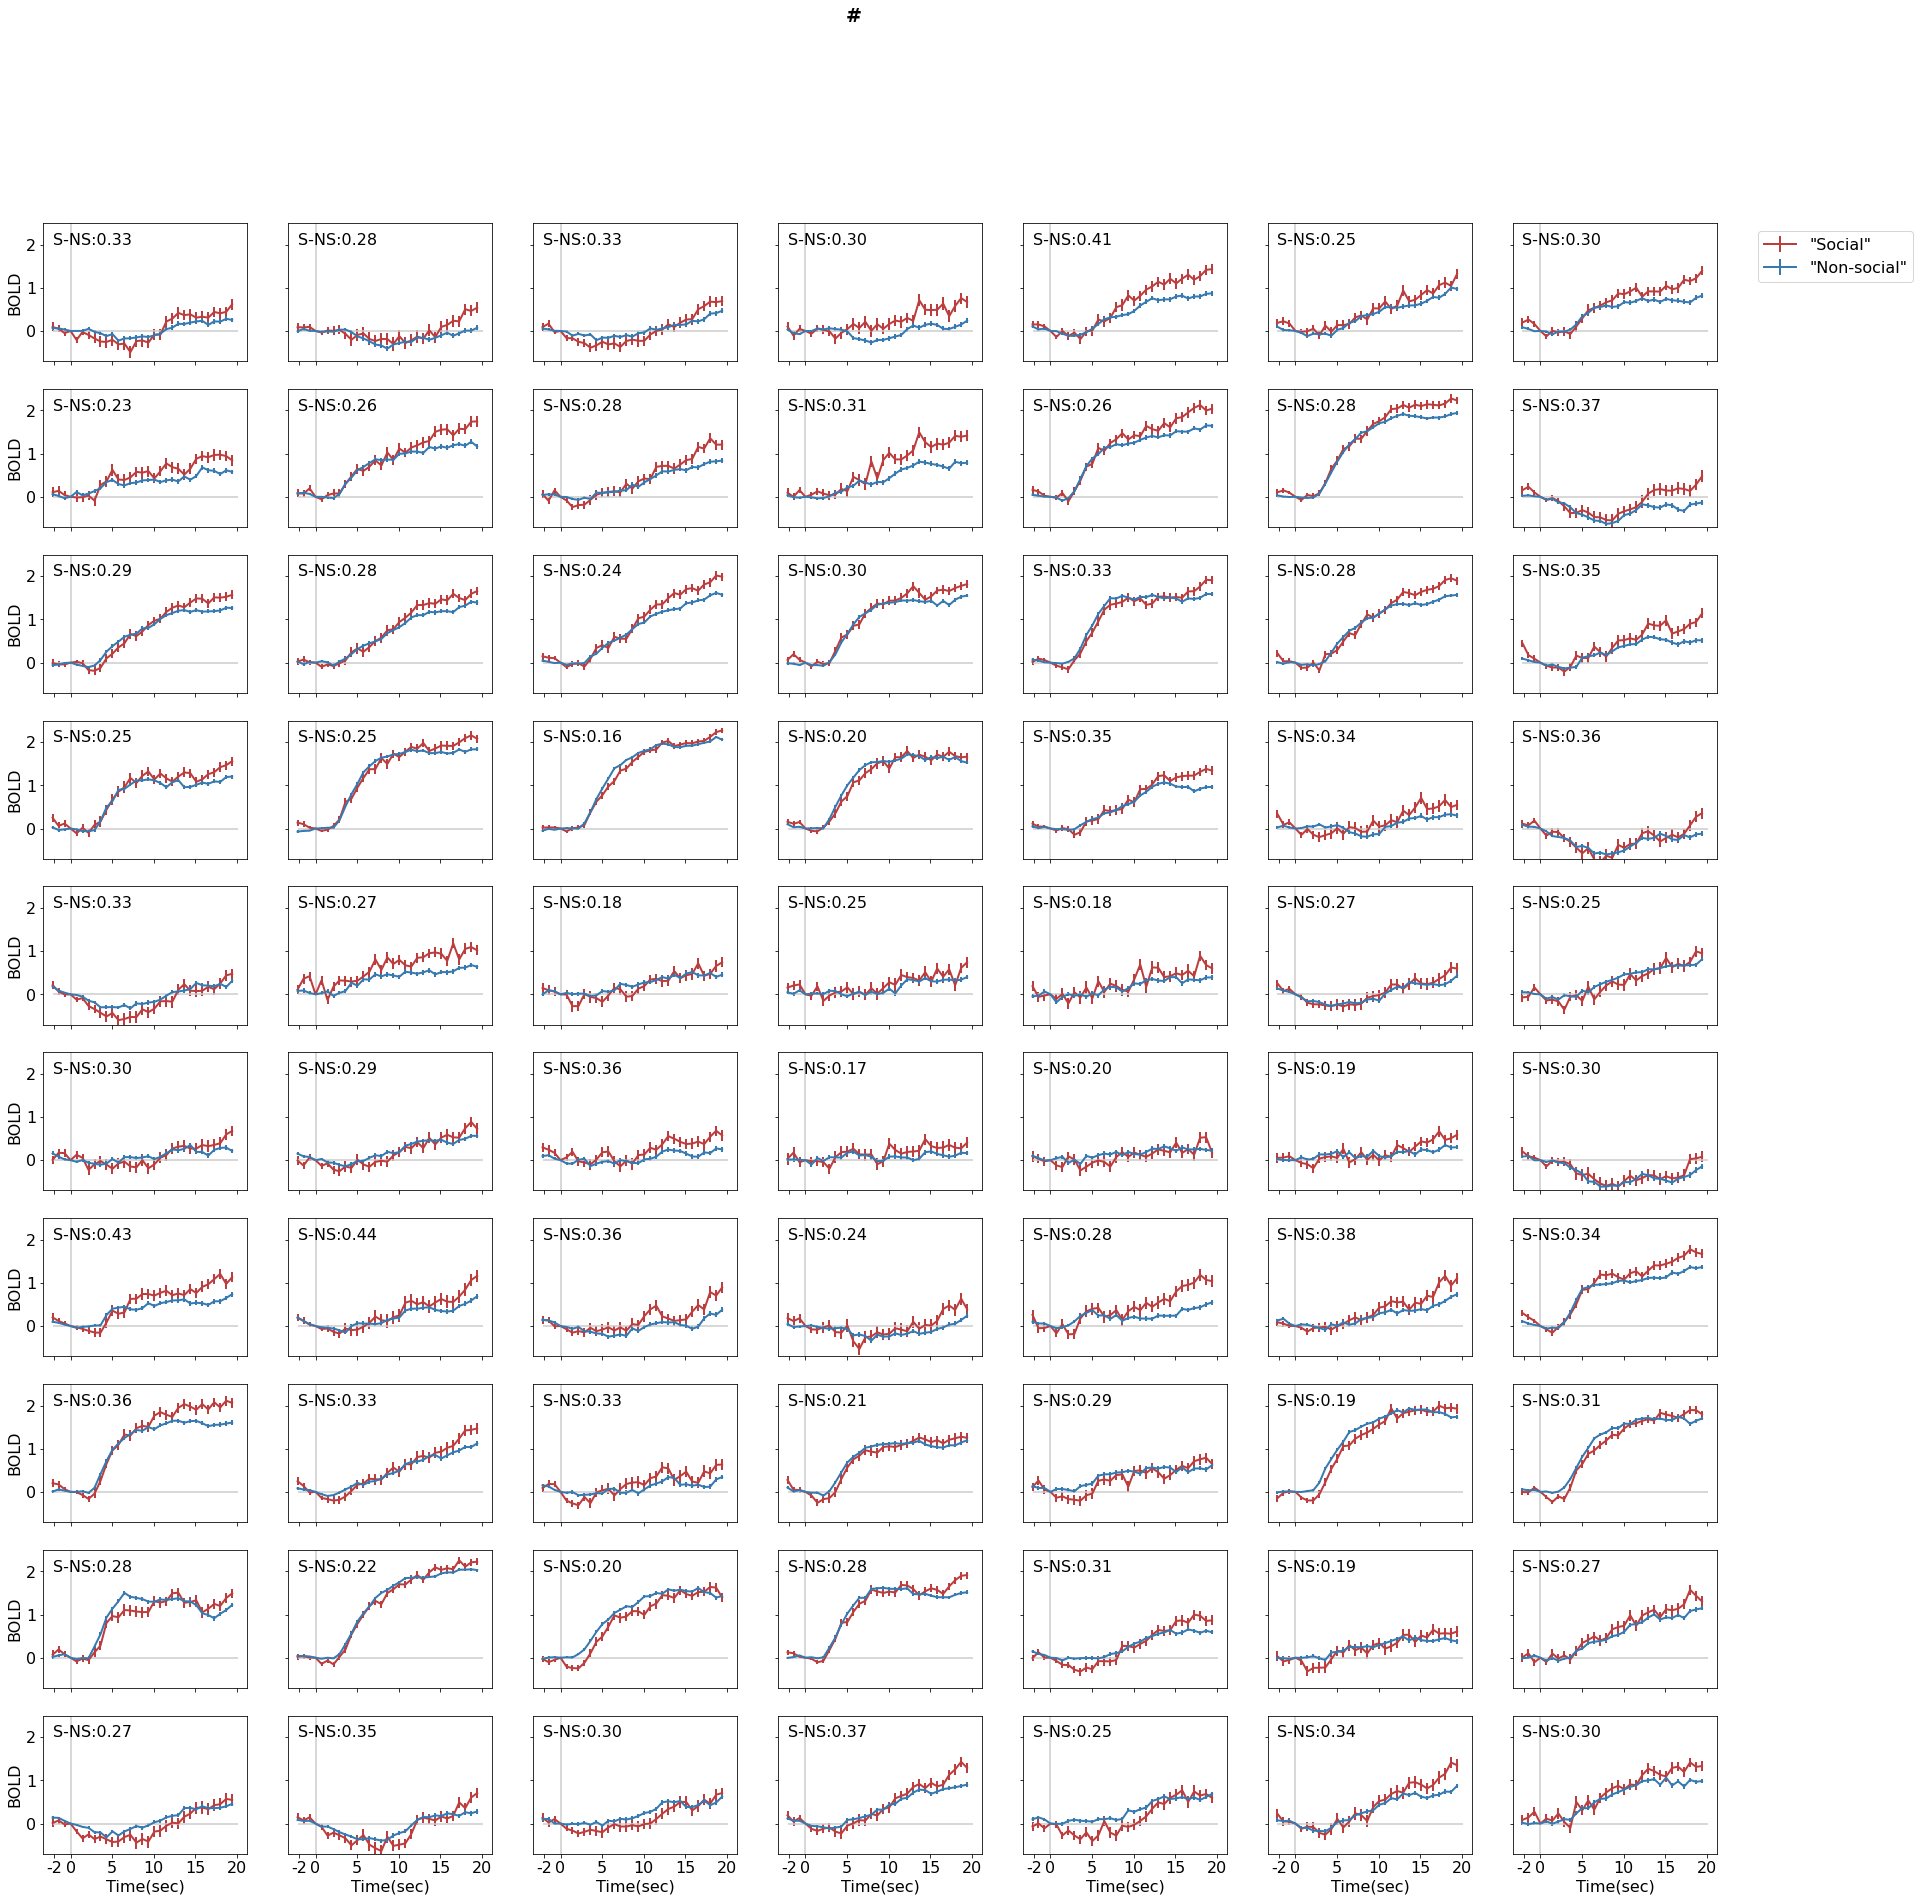

In [657]:
plot_type = 'rand' # CHANGE WHAT TO PLOT HERE!! 'rand', 'all','coax-bill' or 'fish'

[ymin,ymax] = [-.7,2.5]
xlbls = [-2,0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]

nrows = 10
nodes = np.where(nodes_coaxbill_rand_all)[0]
ncols = int(np.ceil(len(nodes)/nrows))
#line_loc = []
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey=True, figsize = (30,30)) # figsize = (20,15))

plt.suptitle('#', fontweight='bold')    

for i,n in enumerate(nodes): #for i,n in enumerate(df['Nodes']):
    #fig, ax = plt.figure(i+1,figsize=(10,5))   

    if ncols == 1:
        ax1 = ax[i]
    else:
        r = int(np.floor(i/ncols))
        c = int(i % ncols)
        ax1 = ax[r,c]

    if plot_type == 'rand':
        movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
        movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
        #movieTC_unsure = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
        #movie_yes_or_no = tcs_run_z[(responses[:,4]==1)|(responses[:,4]==0),n,:,4]
    elif plot_type == 'all':
        movieTC_yes = tcs_run_resh_yes[:,n,:]
        movieTC_no  = tcs_run_resh_no[:,n,:]
        #movieTC_unsure  = tcs_run_resh_unsure[:,n,:] 
    elif plot_type == 'coax-bill':
        movieTC_yes = tcs_trial_z[(responses[:,0]==1) & (responses[:,1]==0),n,:,0] # nsubs * ntimepts
        movieTC_no  = tcs_trial_z[(responses[:,0]==1) & (responses[:,1]==0),n,:,1] # nsubs * ntimepts
        #movieTC_unsure = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
        #movie_yes_or_no = tcs_run_z[(responses[:,4]==1)|(responses[:,4]==0),n,:,4]
    
     
    #  
    ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=2,label ='"Social"')
    ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=2,label ='"Non-social"')
    #ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movie_yes_or_no,axis=0),stats.sem(movie_yes_or_no,axis=0,nan_policy='omit'),color = 'k',linewidth=2,label ='"Social"/"Non-social"')
    #ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmedian(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=2,label ='"Unsure"')
    ax1.vlines(tr0_ind,ymin,ymax,color=[.8,.8,.8])
    ax1.hlines(0,0,31,color=[.8,.8,.8])
    ax1.set_ylim(ymin,ymax)
    if plot_type == 'rand':
        ax1.text(0,.8*ymax,f'S-NS:{meanDiff_sl_rand[n]:.2f}')
    elif plot_type == 'all':
        ax1.text(0,.8*ymax,f'S-NS:{meanDiff_sl_all[n]:.2f}')
    elif plot_type == 'coax-bill':
        ax1.text(0,.8*ymax,f'S-NS:{meanDiff_sl_coaxbill[n]:.2f}')

    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(xlbls)
    #ax[r,0].set_ylabel('BOLD\n(a.u.)')
    #txt = '\n'.join(eval(shen268_lbl[str(n+1)][0])['name'].split(';'))
    #ax1.text(35,0,txt)
    if i %ncols==0:
        ax1.set_ylabel('BOLD')# activity (run-nomralized)')
    if r == nrows-1:
        ax1.set_xlabel('Time(sec)')
    if (r==0) & (c==ncols-1):
        ax1.legend(bbox_to_anchor = [2,1])

if ncols > 1:
    for i in range(int(nrows*ncols-len(nodes))):
        ax[r,c+1+i].axis('off')
#plt.tight_layout()

In [34]:
coef_slope_rand.shape

(1048, 268)